In [1]:
# %reset 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import matplotlib.animation as animation
import sys
import sklearn
from datetime import datetime
import tensorflow as tf

np.set_printoptions(precision=3, suppress=True)

In [193]:
## import spreadsheet and select timeframe of interest
from datetime import timedelta
today = datetime.date(datetime.now())
d = datetime.date(datetime.now())
while d.weekday() != 6:
    d += timedelta(1)
sunday = d

dfnfl = pd.read_csv('spreadspoke_scores.csv')
dfnfl.loc[:,'gamedate'] = pd.to_datetime(dfnfl['schedule_date'])
dfnfl.loc[:,'scoredif'] = dfnfl['score_home'] - dfnfl['score_away']
dfnfltime = dfnfl[dfnfl['gamedate'] > pd.to_datetime('2004-07-31')]
dfnfltime = dfnfltime[dfnfltime['gamedate'] < pd.to_datetime('2020-7-20')]
teams = dfnfltime['team_home'].unique()
teamsid = dfnfltime['team_favorite_id'].unique()
dfnfltime

dfnflsunday = dfnfl[dfnfl['gamedate'] == pd.to_datetime(sunday)]

#create dictionary of teams and shortnames
teams_save = ['Chicago Bears', 'St. Louis Rams','Arizona Cardinals', 'Carolina Panthers',
       'Cleveland Browns', 'Dallas Cowboys', 'Jacksonville Jaguars',
       'Los Angeles Chargers', 'Miami Dolphins', 'Minnesota Vikings',
       'New England Patriots', 'New York Jets', 'Philadelphia Eagles',
       'Seattle Seahawks', 'Tampa Bay Buccaneers', 'New Orleans Saints',
       'Las Vegas Raiders','Oakland Raiders', 'Atlanta Falcons', 'Baltimore Ravens',
       'Cincinnati Bengals', 'Denver Broncos', 'Detroit Lions',
       'Green Bay Packers', 'Houston Texans', 'Los Angeles Rams',
       'New York Giants', 'Pittsburgh Steelers', 'Tennessee Titans',
       'Washington Redskins', 'Buffalo Bills', 'Indianapolis Colts','San Diego Chargers',
       'Kansas City Chiefs', 'San Francisco 49ers'] 

ids = ['CHI', 'STL','ARI', 'CAR', 'CLE', 'DAL', 'JAC', 'LAC', 'MIA', 'MIN', 'NE',
       'NYJ', 'PHI', 'SEA', 'TB', 'NO', 'LV','OAK', 'ATL', 'BAL', 'CIN', 'DEN',
       'DET', 'GB', 'HOU', 'LAR', 'NYG', 'PIT', 'TEN', 'WAS', 'BUF',
       'IND','SD', 'KC','SF']
teamids = {teams_save[i]: ids[i] for i in range(len(teams_save))}
#teamids = {teams[i]: teamsid[i] for i in range(len(teams))}

#split dataframe from game indexed (home and away) to each teams score and spread
dfnfltimehome = dfnfltime[['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home','team_favorite_id','spread_favorite','gamedate', 'scoredif']]
dfnfltimehome.loc[:,'team'] = dfnfltimehome['team_home']
dfnfltimehome.loc[:,'score'] = dfnfltimehome['score_home']
dfnfltimeaway = dfnfltime[['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_away', 'score_away','team_favorite_id','spread_favorite','gamedate', 'scoredif']]
dfnfltimeaway.loc[:,'team'] = dfnfltimeaway['team_away']
dfnfltimeaway.loc[:,'score'] = dfnfltimeaway['score_away']
dfnfltimeaway.loc[:,'scoredif'] = -dfnfltimeaway['scoredif']
dfnfltimesingle = pd.concat([dfnfltimehome,dfnfltimeaway])
dfnfltimesingle.drop(['score_home', 'team_home','team_away','score_away'], axis=1, inplace=True)
teamids

#calculate each teams score ATS and whether covered ATS
def spread(team,team_favorite_id,scoredif,spread_favorite,teamids):
    if teamids[team] == team_favorite_id:
        spreadscore = scoredif + spread_favorite
        if spreadscore > 0:
            cover = 1
        if spreadscore < 0:
            cover = -1
        if spreadscore == 0:
            cover = 0
            
    if teamids[team] != team_favorite_id:
        spreadscore = scoredif - spread_favorite
        if spreadscore > 0:
            cover = 1
        if spreadscore < 0:
            cover = -1
        if spreadscore == 0:
            cover = 0
    return spreadscore
def cover(team,team_favorite_id,scoredif,spread_favorite,teamids):
    if teamids[team] == team_favorite_id:
        spreadscore = scoredif + spread_favorite
        if spreadscore > 0:
            cover = 1
        if spreadscore < 0:
            cover = -1
        if spreadscore == 0:
            cover = 0
            
    if teamids[team] != team_favorite_id:
        spreadscore = scoredif - spread_favorite
        if spreadscore > 0:
            cover = 1
        if spreadscore < 0:
            cover = -1
        if spreadscore == 0:
            cover = 0
    return cover

dfnfltimesingle['spreadscore'] = dfnfltimesingle.apply(lambda row: spread(row['team'],row['team_favorite_id'],row['scoredif'],row['spread_favorite'],teamids),axis=1)
dfnfltimesingle['cover'] = dfnfltimesingle.apply(lambda row: cover(row['team'],row['team_favorite_id'],row['scoredif'],row['spread_favorite'],teamids),axis=1)


#regular season only
dfnfltimesingle = dfnfltimesingle[dfnfltimesingle['schedule_playoff']== False]
dfnfltimesingle.drop(['schedule_playoff'], axis=1, inplace=True)
# dfnfltimesingle.sort_values(by=['schedule_week'],inplace = True)
dfnfltimesingle = dfnfltimesingle.reset_index()


### get each teams score ATS each week of the season, concat seasons vertically
years = dfnfltimesingle['schedule_season'].unique()
dfspreadall = []
dfcoverall = []
for year in years:
    print(year)
    dfnfltimesingleloop = dfnfltimesingle[dfnfltimesingle['schedule_season']==year]
    dfnfltimesingleloop.sort_values(by=['gamedate'],inplace=True)
    #create dataframe of score ATS for each team through the season
    dfspread = pd.DataFrame(dfnfltimesingleloop[dfnfltimesingle['team'] == teams_save[0]]['spreadscore']).reset_index(drop=True)
    for team in teams_save:
        if team != teams_save[0]:
            seasonspread = pd.DataFrame(dfnfltimesingleloop[dfnfltimesingleloop['team'] == team]['spreadscore']).reset_index(drop=True)
            dfspread = pd.concat([dfspread,seasonspread],axis=1)    
    dfspread.columns = teams_save
    dfspread = dfspread.transpose()
    #drop las vegas raiders because they didnt exist yet
    dfspread.dropna(inplace=True)


    #create dataframe of score ATS for each team through the season
    dfcover = pd.DataFrame(dfnfltimesingleloop[dfnfltimesingleloop['team'] == teams_save[0]]['cover']).reset_index(drop=True)
    for team in teams_save:
        if team != teams_save[0]:
            seasoncover = pd.DataFrame(dfnfltimesingleloop[dfnfltimesingleloop['team'] == team]['cover']).reset_index(drop=True)
            dfcover = pd.concat([dfcover,seasoncover],axis=1)    
    dfcover.columns = teams_save
    dfcover = dfcover.transpose()
    #drop las vegas raiders because they didnt exist yet
    dfcover.dropna(inplace=True)
    dfspreadall.append(dfspread)
    dfcoverall.append(dfcover)
dfspreadall = pd.concat(dfspreadall)
dfcoverall = pd.concat(dfcoverall)
dfspreadall

dfspreadall.to_excel('dfspreadall.xlsx')
dfcoverall.to_excel('dfcoverdall.xlsx')


C:\Users\hogan\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\hogan\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


2004
2005
2006
2007
2008


C:\Users\hogan\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\hogan\AppData\Local\Temp/ipykernel_41860/3632179027.py:114: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfspread = pd.DataFrame(dfnfltimesingleloop[dfnfltimesingle['team'] == teams_save[0]]['spreadscore']).reset_index(drop=True)


2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


In [228]:
df = dfspreadall

#####need to think how to use a 3d dataframe
#df = df.values.reshape(df.shape[1],16,1)

#for now use all games consecutively
df = df.values.reshape(-1,1)
df = pd.DataFrame(df)
df

,0
0,-5.5
1,20.0
2,7.0
3,-1.5
4,-4.5
...,...
8187,2.5
8188,3.5
8189,-17.0
8190,-4.0


In [455]:
df = dfspreadall
games = 7 ##past games to consider while predicting next one
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
# define input sequence
# choose a number of time steps
# split into samples    
X = []
y = []
for i in range(len(df)):
    raw_seq = df.iloc[i]
    # choose a number of time steps
    n_steps = games
    # split into samples
    Xteam, yteam = split_sequence(raw_seq, n_steps)
    X.append(Xteam[0:])
    y.append(yteam[0:])
X = array([item for sublist in X for item in sublist])
y = array([item for sublist in y for item in sublist])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [456]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
# fit model
model.fit(X_train, y_train, epochs=200, verbose=1)

score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

Epoch 1/200
97/97 [==============================] - 1s 2ms/step - loss: 185.2944 - accuracy: 0.0253
Epoch 2/200
97/97 [==============================] - 0s 2ms/step - loss: 184.8326 - accuracy: 0.0243
Epoch 3/200
97/97 [==============================] - 0s 2ms/step - loss: 184.5022 - accuracy: 0.0246
Epoch 4/200
97/97 [==============================] - 0s 2ms/step - loss: 184.3847 - accuracy: 0.0243
Epoch 5/200
97/97 [==============================] - 0s 2ms/step - loss: 184.0828 - accuracy: 0.0230
Epoch 6/200
97/97 [==============================] - 0s 2ms/step - loss: 183.6823 - accuracy: 0.0243
Epoch 7/200
97/97 [==============================] - 0s 2ms/step - loss: 183.2947 - accuracy: 0.0224
Epoch 8/200
97/97 [==============================] - 0s 2ms/step - loss: 183.2984 - accuracy: 0.0233
Epoch 9/200
97/97 [==============================] - 0s 2ms/step - loss: 182.4671 - accuracy: 0.0217
Epoch 10/200
97/97 [==============================] - 0s 2ms/step - loss: 182.2625 - accura

97/97 [==============================] - 0s 2ms/step - loss: 74.6709 - accuracy: 0.0275
Epoch 82/200
97/97 [==============================] - 0s 2ms/step - loss: 73.3557 - accuracy: 0.0275
Epoch 83/200
97/97 [==============================] - 0s 2ms/step - loss: 71.8767 - accuracy: 0.0253
Epoch 84/200
97/97 [==============================] - 0s 2ms/step - loss: 70.6855 - accuracy: 0.0253
Epoch 85/200
97/97 [==============================] - 0s 2ms/step - loss: 70.4566 - accuracy: 0.0240
Epoch 86/200
97/97 [==============================] - 0s 2ms/step - loss: 70.1685 - accuracy: 0.0236
Epoch 87/200
97/97 [==============================] - 0s 2ms/step - loss: 71.4159 - accuracy: 0.0246
Epoch 88/200
97/97 [==============================] - 0s 2ms/step - loss: 69.8679 - accuracy: 0.0259
Epoch 89/200
97/97 [==============================] - 0s 2ms/step - loss: 71.1527 - accuracy: 0.0266
Epoch 90/200
97/97 [==============================] - 0s 2ms/step - loss: 70.1220 - accuracy: 0.0269
Epo

97/97 [==============================] - 0s 2ms/step - loss: 35.3568 - accuracy: 0.0285
Epoch 162/200
97/97 [==============================] - 0s 2ms/step - loss: 36.6113 - accuracy: 0.0269
Epoch 163/200
97/97 [==============================] - 0s 2ms/step - loss: 37.1174 - accuracy: 0.0292
Epoch 164/200
97/97 [==============================] - 0s 2ms/step - loss: 36.1328 - accuracy: 0.0275
Epoch 165/200
97/97 [==============================] - 0s 2ms/step - loss: 37.1220 - accuracy: 0.0295
Epoch 166/200
97/97 [==============================] - 0s 2ms/step - loss: 35.2980 - accuracy: 0.0272
Epoch 167/200
97/97 [==============================] - 0s 2ms/step - loss: 37.5314 - accuracy: 0.0262
Epoch 168/200
97/97 [==============================] - 0s 2ms/step - loss: 39.7768 - accuracy: 0.0256
Epoch 169/200
97/97 [==============================] - 0s 2ms/step - loss: 42.3065 - accuracy: 0.0275
Epoch 170/200
97/97 [==============================] - 0s 2ms/step - loss: 36.7612 - accuracy: 0

C:\Users\hogan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

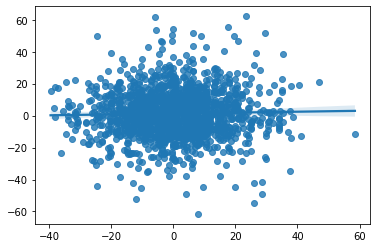

In [457]:
# demonstrate prediction
ypred = []
ytest = []
for game in range(len(y_test)):
    x_input = X_test[game]
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
#     print(yhat[0][0])
#     print(y_test[game])
    ypred.append(yhat[0][0])
    ytest.append(y_test[game])

import seaborn as sns
sns.regplot(ytest,ypred)

In [ ]:
##### So far no predictive power using old spreads to predict next games

In [ ]:
#### LSTM #####
#and others before

df = dfspreadall
#####need to think how to use a 3d dataframe
#df = df.values.reshape(df.shape[1],16,1)

#for now use all games consecutively, two rows
df = df.values.reshape(-1,1)
df = pd.DataFrame(df)
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]


In [230]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [231]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [232]:
label = 0

w1 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=[label])
w1

w2 = WindowGenerator(input_width=3, label_width=1, shift=1,
                     label_columns=[label])
w2

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): [0]

In [233]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [234]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[3:3+w2.total_window_size]),
                           np.array(train_df[6:6+w2.total_window_size])])

print(train_df[:w2.total_window_size])
print(train_df[3:3+w2.total_window_size])
print(train_df[6:6+w2.total_window_size])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

          0
0 -0.431669
1  1.403163
2  0.467759
3 -0.143852
          0
3 -0.143852
4 -0.359714
5 -0.395692
6  0.539713
          0
6  0.539713
7  1.115346
8  0.503736
9 -1.690867
All shapes are: (batch, time, features)
Window shape: (3, 4, 1)
Inputs shape: (3, 3, 1)
labels shape: (3, 1, 1)


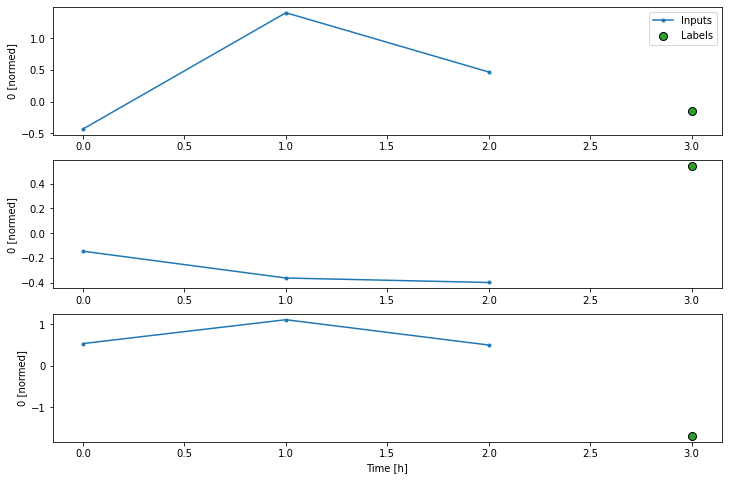

In [235]:
w2.example = example_inputs, example_labels
def plot(self, model=None, plot_col=0, max_subplots=5):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

w2.plot()

In [236]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=5000,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [237]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [238]:
# Each element is an (inputs, label) pair
w2.train.element_spec
w2.val.element_spec
w2.test.element_spec

(TensorSpec(shape=(None, 3, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [239]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (5000, 3, 1)
Labels shape (batch, time, features): (5000, 1, 1)


In [240]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[label])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): [0]

In [241]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (5000, 1, 1)
Labels shape (batch, time, features): (5000, 1, 1)


In [242]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[label])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): [0]

In [243]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (5000, 1, 1)
Labels shape (batch, time, features): (5000, 1, 1)


In [244]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [245]:
#### baseline model simply predicts same as last game
baseline = Baseline(label_index=column_indices[label])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 97ms/step - loss: 1.6551 - mean_absolute_error: 1.0047


In [283]:
threegame_window = WindowGenerator(
    input_width=3, label_width=3, shift=1,
    label_columns=[label])

threegame_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): [0]

Input shape: (5000, 7, 1)
Output shape: (5000, 7, 1)


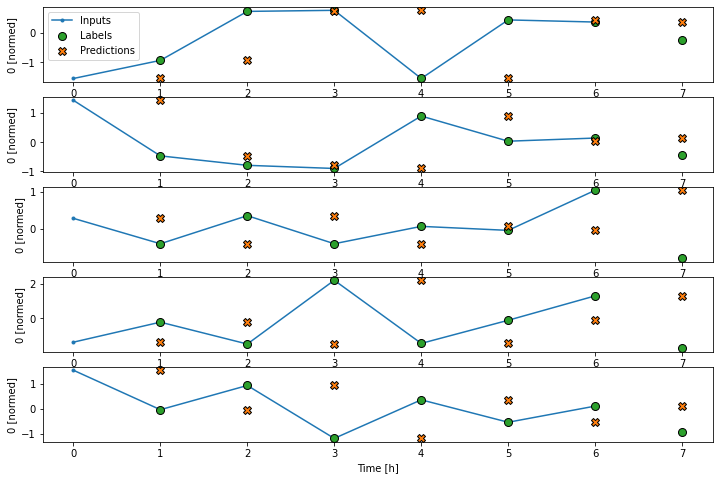

In [284]:
print('Input shape:', threegame_window.example[0].shape)
print('Output shape:', baseline(threegame_window.example[0]).shape)
threegame_window.plot(baseline)

In [285]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=[label])

wide_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): [0]

In [298]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [299]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (5000, 1, 1)
Output shape: (5000, 1, 1)


In [300]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [301]:
history = compile_and_fit(linear, wide_window)

val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

Epoch 1/20
2/2 [==============================] - 1s 166ms/step - loss: 3.2571 - mean_absolute_error: 1.4193 - val_loss: 2.7961 - val_mean_absolute_error: 1.3183
Epoch 2/20
2/2 [==============================] - 0s 64ms/step - loss: 3.2511 - mean_absolute_error: 1.4180 - val_loss: 2.7911 - val_mean_absolute_error: 1.3172
Epoch 3/20
2/2 [==============================] - 0s 74ms/step - loss: 3.2451 - mean_absolute_error: 1.4167 - val_loss: 2.7860 - val_mean_absolute_error: 1.3160
Epoch 4/20
2/2 [==============================] - 0s 82ms/step - loss: 3.2391 - mean_absolute_error: 1.4154 - val_loss: 2.7809 - val_mean_absolute_error: 1.3149
Epoch 5/20
2/2 [==============================] - 0s 64ms/step - loss: 3.2331 - mean_absolute_error: 1.4141 - val_loss: 2.7758 - val_mean_absolute_error: 1.3137
Epoch 6/20
2/2 [==============================] - 0s 75ms/step - loss: 3.2272 - mean_absolute_error: 1.4128 - val_loss: 2.7707 - val_mean_absolute_error: 1.3125
Epoch 7/20
2/2 [=================

Input shape: (5000, 7, 1)
Output shape: (5000, 7, 1)


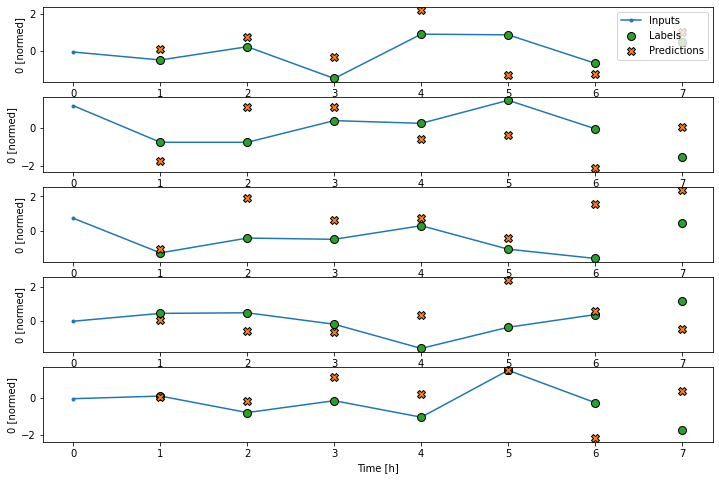

In [303]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
wide_window.plot(linear)

Epoch 1/20
2/2 [==============================] - 1s 175ms/step - loss: 1.0061 - mean_absolute_error: 0.7841 - val_loss: 0.8507 - val_mean_absolute_error: 0.7062
Epoch 2/20
2/2 [==============================] - 0s 75ms/step - loss: 1.0002 - mean_absolute_error: 0.7819 - val_loss: 0.8479 - val_mean_absolute_error: 0.7046
Epoch 3/20
2/2 [==============================] - 0s 75ms/step - loss: 1.0007 - mean_absolute_error: 0.7816 - val_loss: 0.8480 - val_mean_absolute_error: 0.7050
Epoch 4/20
1/1 [==============================] - 0s 59ms/step - loss: 0.8481 - mean_absolute_error: 0.7049


Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

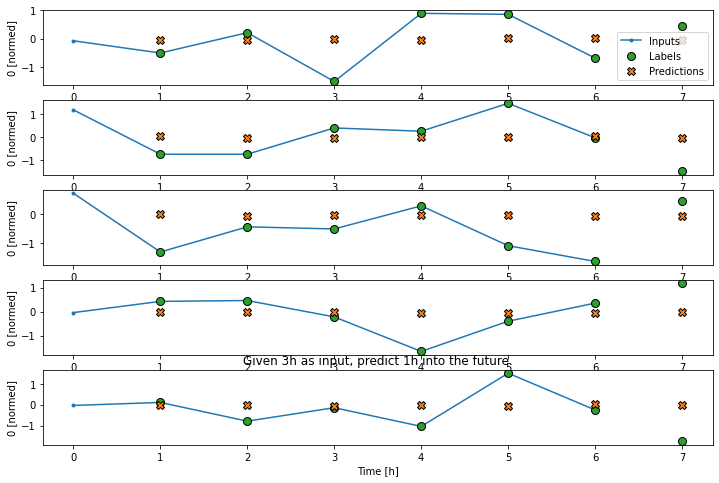

In [304]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, wide_window)

val_performance['Dense'] = dense.evaluate(wide_window.val)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

%matplotlib inline
wide_window.plot(dense)
plt.title("Given 3h as input, predict 1h into the future.")

In [305]:
CONV_WIDTH = 7
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[label])

conv_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): [0]

In [306]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (5000, 7, 1)
Output shape: (5000, 1, 1)


In [307]:
import IPython
history = compile_and_fit(multi_step_dense, conv_window)

%matplotlib widget
IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 62ms/step - loss: 0.8637 - mean_absolute_error: 0.7172


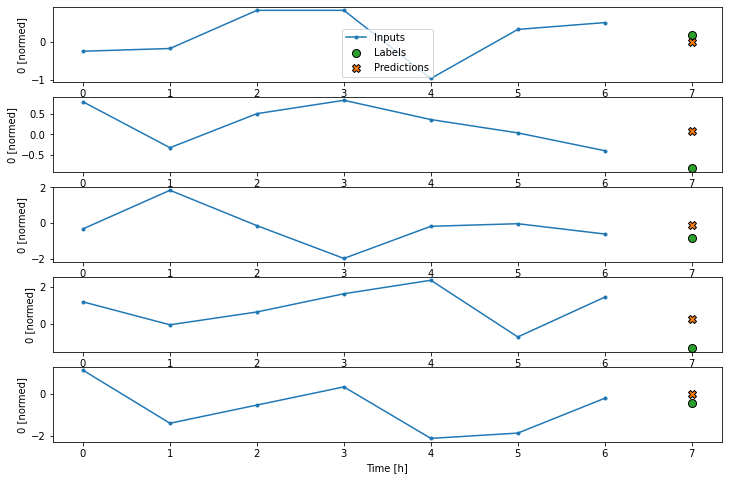

In [308]:
%matplotlib inline
conv_window.plot(multi_step_dense)

In [309]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (5000, 7, 1)
Output shape: (5000, 1, 1)


In [310]:
conv_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): [0]

In [311]:
history = compile_and_fit(conv_model, conv_window)

import IPython.display
IPython.display.clear_output()
#cant bring test and val scores to final df, code below tries to do that
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

1/1 [==============================] - 0s 59ms/step - loss: 0.8510 - mean_absolute_error: 0.7083


Wide window
Input shape: (5000, 7, 1)
Labels shape: (5000, 1, 1)
Output shape: (5000, 1, 1)


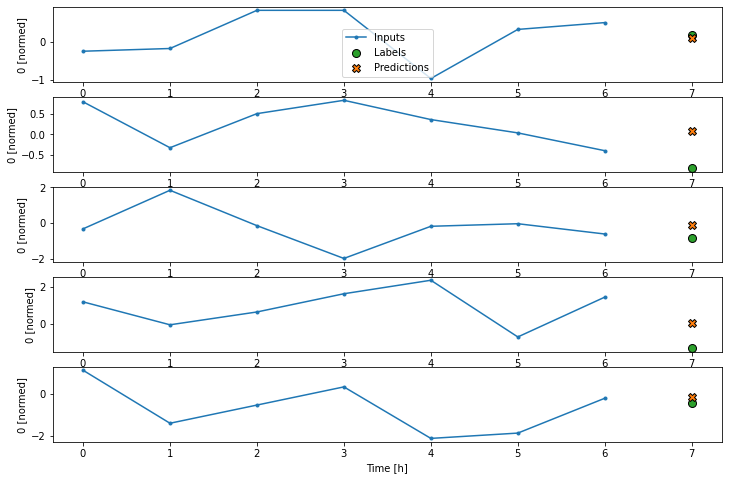

In [312]:
print("Wide window")
print('Input shape:', conv_window.example[0].shape)
print('Labels shape:', conv_window.example[1].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)
conv_window.plot(conv_model)

In [317]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (5000, 7, 1)
Output shape: (5000, 7, 1)


In [318]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (5000, 7, 1)
Output shape: (5000, 7, 1)


In [319]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 76ms/step - loss: 0.8499 - mean_absolute_error: 0.7064


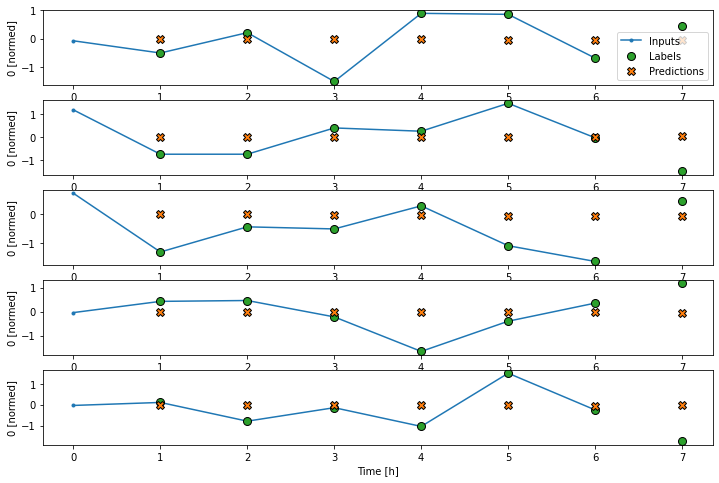

In [320]:
wide_window.plot(lstm_model)

Baseline    : 1.0516
Linear      : 1.3467
Dense       : 0.7345
Multi step dense: 0.7475
Conv        : 0.7386
LSTM        : 0.7369


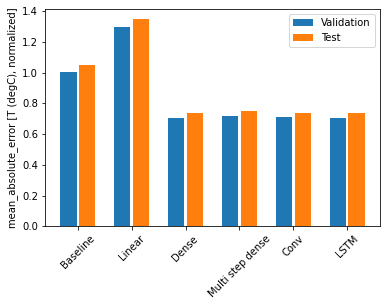

In [316]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

In [449]:
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
# define input sequence
# choose a number of time steps
# split into samples    
X = []
y = []
for i in range(len(df)):
    raw_seq = df.iloc[i]
    # choose a number of time steps
    n_steps = 3
    # split into samples
    Xteam, yteam = split_sequence(raw_seq, n_steps)
    X.append(Xteam[0:])
    y.append(yteam[0:])
X = array([item for sublist in X for item in sublist])
y = array([item for sublist in y for item in sublist])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [450]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(5, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
# fit model
model.fit(X_train, y_train, epochs=200, verbose=1)

score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

Epoch 1/200
140/140 [==============================] - 1s 1ms/step - loss: 186.4497 - accuracy: 0.0229
Epoch 2/200
140/140 [==============================] - 0s 1ms/step - loss: 185.1380 - accuracy: 0.0240
Epoch 3/200
140/140 [==============================] - 0s 1ms/step - loss: 184.5965 - accuracy: 0.0269
Epoch 4/200
140/140 [==============================] - 0s 1ms/step - loss: 184.3033 - accuracy: 0.0285
Epoch 5/200
140/140 [==============================] - 0s 1ms/step - loss: 184.1163 - accuracy: 0.0283
Epoch 6/200
140/140 [==============================] - 0s 1ms/step - loss: 184.0095 - accuracy: 0.0309
Epoch 7/200
140/140 [==============================] - 0s 1ms/step - loss: 183.9307 - accuracy: 0.0314
Epoch 8/200
140/140 [==============================] - 0s 1ms/step - loss: 183.8564 - accuracy: 0.0323
Epoch 9/200
140/140 [==============================] - 0s 1ms/step - loss: 183.8241 - accuracy: 0.0312
Epoch 10/200
140/140 [==============================] - 0s 1ms/step - los

140/140 [==============================] - 0s 938us/step - loss: 182.2473 - accuracy: 0.0256
Epoch 80/200
140/140 [==============================] - 0s 948us/step - loss: 182.2512 - accuracy: 0.0247
Epoch 81/200
140/140 [==============================] - 0s 947us/step - loss: 182.1771 - accuracy: 0.0251
Epoch 82/200
140/140 [==============================] - 0s 952us/step - loss: 182.1604 - accuracy: 0.0251
Epoch 83/200
140/140 [==============================] - 0s 946us/step - loss: 182.1893 - accuracy: 0.0247
Epoch 84/200
140/140 [==============================] - 0s 1ms/step - loss: 182.1753 - accuracy: 0.0256
Epoch 85/200
140/140 [==============================] - 0s 1ms/step - loss: 182.1581 - accuracy: 0.0244
Epoch 86/200
140/140 [==============================] - 0s 949us/step - loss: 182.1420 - accuracy: 0.0251
Epoch 87/200
140/140 [==============================] - 0s 946us/step - loss: 182.0735 - accuracy: 0.0251
Epoch 88/200
140/140 [==============================] - 0s 944u

140/140 [==============================] - 0s 1ms/step - loss: 181.2438 - accuracy: 0.0256
Epoch 157/200
140/140 [==============================] - 0s 1ms/step - loss: 181.1993 - accuracy: 0.0280
Epoch 158/200
140/140 [==============================] - 0s 1ms/step - loss: 181.2339 - accuracy: 0.0262
Epoch 159/200
140/140 [==============================] - 0s 1ms/step - loss: 181.1388 - accuracy: 0.0265
Epoch 160/200
140/140 [==============================] - 0s 1ms/step - loss: 181.2202 - accuracy: 0.0269
Epoch 161/200
140/140 [==============================] - 0s 1ms/step - loss: 181.1104 - accuracy: 0.0258
Epoch 162/200
140/140 [==============================] - 0s 1ms/step - loss: 181.1286 - accuracy: 0.0262
Epoch 163/200
140/140 [==============================] - 0s 1ms/step - loss: 181.1036 - accuracy: 0.0256
Epoch 164/200
140/140 [==============================] - ETA: 0s - loss: 180.9608 - accuracy: 0.02 - 0s 1ms/step - loss: 181.0930 - accuracy: 0.0267
Epoch 165/200
140/140 [==

C:\Users\hogan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

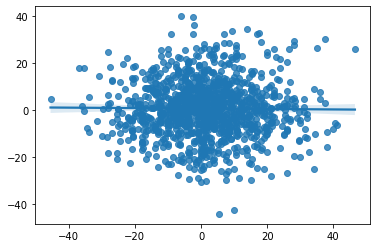

In [437]:
# demonstrate prediction
ypred = []
ytest = []
for game in range(len(y_test)):
    x_input = X_test[game]
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
#     print(yhat[0][0])
#     print(y_test[game])
    ypred.append(yhat[0][0])
    ytest.append(y_test[game])

import seaborn as sns
sns.regplot(ytest,ypred)

In [439]:
scores = model.evaluate(X_test, y_test), verbose=0)

SyntaxError: cannot assign to function call (Temp/ipykernel_41860/1094791727.py, line 1)